<a href="https://colab.research.google.com/github/187ram/Dog-Breed-Identification-CNN/blob/main/Dog_Breed_Identification_(Kaggle)_Using_Pretrained_ResNet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Totality Corp
## Assignment
**Part 1**

Build a dog breed image classification model with the architecture specified below.

**Dataset** - https://www.kaggle.com/c/dog-breed-identification/data


###Fetching data from kaggle 

In [77]:
# #@title
# ! pip install -q kaggle

In [78]:
# #@title
# from google.colab import files
# files.upload()

In [79]:
# #@title
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/

In [80]:
#@title
# ! chmod 600 ~/.kaggle/kaggle.json

In [81]:
#@title
# ! kaggle datasets download -d ram187/dog-breed-identification

In [82]:
#@title
# !unzip /content/dog-breed-identification.zip

# Dog Breed Identification
The classifier only predict scores for these breeds : beagle, chihuahua, doberman,
french_bulldog, golden_retriever, malamute, pug, saint_bernard, scottish_deerhound,
tibetan_mastiff.

# Data Pre-Proccessing

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import os
from shutil import copyfile
import matplotlib.pyplot as plt
#%matplotlib inline

In [84]:
labels = pd.read_csv('labels.csv')
selected_breed_list = ['beagle', 'chihuahua', 'doberman','french_bulldog', 'golden_retriever', 'malamute', 
                      'pug', 'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff']

labels = labels[labels['breed'].isin(selected_breed_list)]

In [85]:
labels_dict = {i:j for i,j in zip(labels['id'],labels['breed'])}
classes = set(labels_dict.values())
images = [f for f in os.listdir('train')]
print(len(images),images[0])

10222 1015e4eba660def32e7e52b89fe3a9c6.jpg


In [86]:
temp = '.'.join((labels.loc[labels.index[840], 'id'],'jpg'))

In [87]:
new_image = []
for item in range(labels.size//2-1):
    if  '.'.join((labels.loc[labels.index[item], 'id'],'jpg')) in images:
        new_image.append('.'.join((labels.loc[labels.index[item], 'id'],'jpg')))

In [88]:
if  not os.path.exists('training_images'):
        os.makedirs('training_images')

if  not os.path.exists('validation_images'):
    os.makedirs('validation_images')

In [89]:
os.chdir('training_images')
for curClass in classes:    
    if  not os.path.exists(curClass):
        os.makedirs(curClass)
        #os.rmdir(curClass)

os.chdir('../validation_images')
for curClass in classes:    
    if  not os.path.exists(curClass):
        os.makedirs(curClass)

In [90]:
os.chdir('..')
count = 0 
destination_directory = 'training_images/'
for item in new_image:
    if count >680:
        destination_directory = 'validation_images/'
    filekey = os.path.splitext(item)[0]
    if  not os.path.exists(destination_directory+labels_dict[filekey]+'/'+item):
        copyfile('train/'+item, destination_directory+labels_dict[filekey]+'/'+item)
    #print(labels_dict[filekey])
    count +=1

# Displaying the original image of "Tibetan_Mastiff"

In [107]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

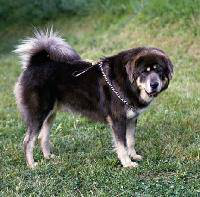

In [108]:
img = load_img('training_images/tibetan_mastiff/70fe05acafe344e3359dd4742aedbc05.jpg') 
img

##image augmentation for 3 trials of "Tibetan_Mastiff "

In [110]:
datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.3,
        height_shift_range=0.2,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('training_images/tibetan_mastiff/70fe05acafe344e3359dd4742aedbc05.jpg') 
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='dog_breed', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

## Displaying the image after image augmentation of "Tibetan_Mastiff "

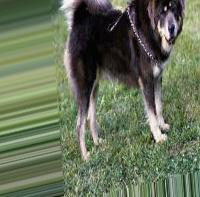

In [111]:
img1=load_img('preview/dog_breed_0_6288.jpeg')
img1

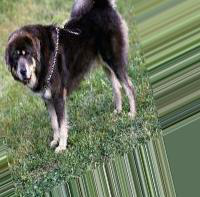

In [112]:
img2=load_img('preview/dog_breed_0_7267.jpeg')
img2

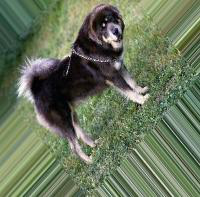

In [113]:
img3=load_img('preview/dog_breed_0_9294.jpeg')
img3

# Implementing Resnet50 Convolution Neural Network architecture.

In [91]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.utils import layer_utils
from keras import backend as K
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

**Import ResNet50 weights trained on ImageNet**

In [92]:
#General idea: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
#The author of this article tried to classify dogs vs cats with a pretrained model and provides an abstract idea 
model = ResNet50(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

##Add 5 hidden layers and an output layer

In [93]:
x = model.output
x = Flatten()(x)
x=Dropout(0.25)(x)
x=Dense(units=1000,activation='relu')(x)
x=Dropout(0.25)(x)
x=Dense(units=750,activation='relu')(x)
x=Dropout(0.25)(x)
x=Dense(units=750,activation='relu')(x)
x=Dropout(0.25)(x)
x=Dense(units=750,activation='relu')(x)
x=Dropout(0.25)(x)
x=Dense(units=1000,activation='relu')(x)
x=Dropout(0.6)(x)
predictions = Dense(10, activation='softmax')(x)

In [94]:
import keras
main_model = Model(inputs=model.input, outputs=predictions)
#train only the hidden layers and output layer, donot train the resnet model
for curLayer in model.layers:
    curLayer.trainable = False

main_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
main_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

## Image Augmentation

In [95]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
#check class_mode in keras documentation https://keras.io/preprocessing/image/
training_set = train_datagen.flow_from_directory(
        'training_images',
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        'validation_images',
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

Found 681 images belonging to 10 classes.
Found 159 images belonging to 10 classes.


## Model Fit

In [96]:
hist=main_model.fit(
        training_set,
        steps_per_epoch=40,
        epochs=3,
        validation_data=test_set,
        validation_steps=10,callbacks=callbacks_list)

Epoch 1/3
40/40 [==============================] - 10s 176ms/step - loss: 10.7677 - accuracy: 0.0950 - val_loss: 2.3421 - val_accuracy: 0.0700
Epoch 2/3
40/40 [==============================] - 6s 152ms/step - loss: 2.5907 - accuracy: 0.1561 - val_loss: 2.2883 - val_accuracy: 0.1400
Epoch 3/3
40/40 [==============================] - 6s 150ms/step - loss: 2.3734 - accuracy: 0.0874 - val_loss: 2.2943 - val_accuracy: 0.1300


# Obtain Predictions

In [97]:
import os
import cv2
import pandas as pd
import numpy as np
test_set = []
test_set_ids = []
for curImage in os.listdir('test/quick'):
    test_set_ids.append(os.path.splitext(curImage)[0])
    curImage = cv2.imread('test/quick/'+curImage)
    test_set.append(cv2.resize(curImage,(224, 224)))

In [98]:
test_set = np.array(test_set, np.float32)/255.0

In [99]:
#test_set.shape

(49, 224, 224, 3)

In [100]:
predictions= main_model.predict(test_set)

In [101]:
training_set.class_indices

{'beagle': 0,
 'chihuahua': 1,
 'doberman': 2,
 'french_bulldog': 3,
 'golden_retriever': 4,
 'malamute': 5,
 'pug': 6,
 'saint_bernard': 7,
 'scottish_deerhound': 8,
 'tibetan_mastiff': 9}

## Process the Prdictions to an Output File

In [102]:
classes= {index:breed for breed,index in training_set.class_indices.items()}
column_names = [classes[i] for i in range(10)]
column_names

['beagle',
 'chihuahua',
 'doberman',
 'french_bulldog',
 'golden_retriever',
 'malamute',
 'pug',
 'saint_bernard',
 'scottish_deerhound',
 'tibetan_mastiff']

In [106]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = column_names
predictions_df.insert(0,'id', test_set_ids)
predictions_df.set_index('id',inplace=True)
predictions_df.head()

,beagle,chihuahua,doberman,french_bulldog,golden_retriever,malamute,pug,saint_bernard,scottish_deerhound,tibetan_mastiff
id,,,,,,,,,,
4f4e91ba1aed19b1b7dd6bebf4e8c9ca,0.099754,0.099415,0.097964,0.089756,0.100363,0.094896,0.103264,0.099837,0.126548,0.088205
4f0f6b1a0c4b19cc0917f24bfee6d6cd,0.098919,0.097731,0.098523,0.090595,0.099576,0.094623,0.103352,0.099797,0.127781,0.089102
4f7ec53fb020dfd90ac36227ab8233dc,0.099023,0.097452,0.097407,0.091010,0.099041,0.094610,0.103652,0.100355,0.126958,0.090492
6ce2f79bfc8e23d4158f79d1b2d034d1,0.100475,0.097752,0.099148,0.090183,0.101388,0.095702,0.102766,0.099432,0.124878,0.088276
4f0b2dbc23fdef5f939144f456a62140,0.099032,0.097396,0.098679,0.090796,0.099334,0.095003,0.103286,0.099981,0.126882,0.089610


In [104]:
predictions_df.to_csv('final_submission.csv',sep=",")

In [115]:
print(hist.history)

{'loss': [8.399653434753418, 2.508697509765625, 2.3560378551483154], 'accuracy': [0.11764705926179886, 0.13750000298023224, 0.10230179131031036], 'val_loss': [2.34205961227417, 2.2882730960845947, 2.2942798137664795], 'val_accuracy': [0.07000000029802322, 0.14000000059604645, 0.12999999523162842]}


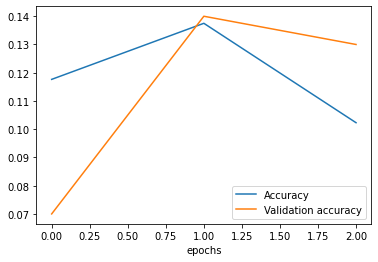

In [116]:
plt.plot(hist.history['accuracy'],label="Accuracy")
plt.plot(hist.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.xlabel('epochs')
plt.show()

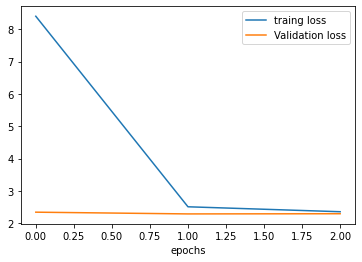

In [117]:
plt.plot(hist.history['loss'],label="traing loss")
plt.plot(hist.history['val_loss'], label="Validation loss")
plt.legend()
plt.xlabel('epochs')
plt.show()